# AlexNet


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds

import keras
from keras.models import Model
from keras.layers import Conv2D, Dropout, MaxPool2D, Dense, Flatten, Input
from tensorflow.nn import local_response_normalization as LRN

## 데이터셋 불러오기

In [ ]:
train_ds, ds_info = tfds.load('imagenette', split='train', with_info=True)
val_ds = tfds.load('imagenette', split='validation', with_info=False)

print(train_ds)
print(val_ds)

<PrefetchDataset element_spec={'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}>
<PrefetchDataset element_spec={'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}>


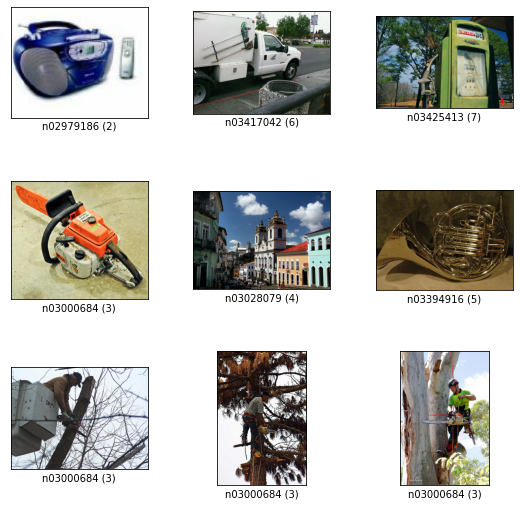

In [ ]:
fig = tfds.show_examples(train_ds, ds_info)

In [ ]:
ds_info

tfds.core.DatasetInfo(
    name='imagenette',
    full_name='imagenette/full-size-v2/1.0.0',
    description="""
    Imagenette is a subset of 10 easily classified classes from the Imagenet
    dataset. It was originally prepared by Jeremy Howard of FastAI. The objective
    behind putting together a small version of the Imagenet dataset was mainly
    because running new ideas/algorithms/experiments on the whole Imagenet take a
    lot of time.
    
    This version of the dataset allows researchers/practitioners to quickly try out
    ideas and share with others. The dataset comes in three variants:
    
    *   Full size
    *   320 px
    *   160 px
    
    Note: The v2 config correspond to the new 70/30 train/valid split (released in
    Dec 6 2019).
    """,
    config_description="""
    full-size variant.
    """,
    homepage='https://github.com/fastai/imagenette',
    data_path='/root/tensorflow_datasets/imagenette/full-size-v2/1.0.0',
    file_format=tfrecord,
    download_

In [ ]:
# label을 출력합니다
ds_info.features["label"].names

['n01440764',
 'n02102040',
 'n02979186',
 'n03000684',
 'n03028079',
 'n03394916',
 'n03417042',
 'n03425413',
 'n03445777',
 'n03888257']

In [ ]:
# Number of classes: 10
num_classes = ds_info.features['label'].num_classes
print("num_classes: ", num_classes)

# Number of images: train 9469 / validation 3925
num_train_imgs = ds_info.splits['train'].num_examples
num_val_imgs = ds_info.splits['validation'].num_examples
print("num_train_imgs: ", num_train_imgs)
print("num_val_imgs: ", num_val_imgs)

num_classes:  10
num_train_imgs:  9469
num_val_imgs:  3925


In [ ]:
import math
import functools

input_shape = [227, 227, 3]
batch_size = 128
num_epochs = 90

def _prepare_data_fn(features, input_shape, augment=False):
    """
    Resize image to expected dimensions, and opt. apply some random transformations.
    이미지 resizing, augmentation 등을 수행합니다.
    
    - features: Data
    - input_shape: Shape expected by the models (images will be resized accordingly)
    - augment: Flag to apply some random augmentations to the images
    - return: Augmented Images, Labels
    """
    input_shape = tf.convert_to_tensor(input_shape)

    # Tensorflow-dataset returns batches as feature dictionaries, expected by Estimators. 
    # To train Keras models, it is more straightforward to return the batch content as tuples. 

    image = features['image']
    label = features['label']

    # 이미지 픽셀 값의 범위를 [0, 255]에서 [0, 1.]로 normalize 합니다.
    image = tf.image.convert_image_dtype(image, tf.float32)

    if augment:

        # 무작위 좌우대칭
        image = tf.image.random_flip_left_right(image)

        # 무작위 밝기/포화도 변화
        image = tf.image.random_brightness(image, max_delta=0.1)
        image = tf.image.random_saturation(image, lower=0.5, upper=1.5)
        image = tf.clip_by_value(image, 0.0, 1.0) # 픽셀 값이 범위 밖으로 넘어가지 않게 확인
        image = tf.image.resize(image, input_shape[:2])

        
    else:
        image = tf.image.resize(image, input_shape[:2])

    return image, label




prepare_data_fn_for_train = functools.partial(_prepare_data_fn, 
                                              input_shape=input_shape,
                                              augment=True)

train_ds = train_ds.repeat(num_epochs).shuffle(2023)

train_ds = train_ds.map(prepare_data_fn_for_train, num_parallel_calls=4)
train_ds = train_ds.batch(batch_size)
train_ds = train_ds.prefetch(1)


# # 배치 크기 적용
# train_ds = train_ds.batch(batch_size)
# train_ds = train_ds.prefetch(1)


# validation dataset (섞거나 증강시키지 않음)
prepare_data_fn_for_val = functools.partial(_prepare_data_fn,
                                           input_shape=input_shape,
                                           augment=False)


val_ds = (val_ds.repeat().map(prepare_data_fn_for_val, num_parallel_calls=4)
                         .batch(batch_size)
                         .prefetch(1))


train_steps_per_epoch = math.ceil(num_train_imgs / batch_size)
val_steps_per_epoch = math.ceil(num_val_imgs / batch_size)

In [ ]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(128, 227, 227, 3)
(128,)


In [ ]:
for image_batch, labels_batch in val_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(128, 227, 227, 3)
(128,)


## 모델
### 구조
- Input: 227 * 227 * 3,
- Conv2D 5층
    - 필터 수 96, 크기 11 * 11, stride 4
        - LRN(k = 2, n = 5, α = 10^(−4), and β = 0.75)
        - pool(stride = 2, filter size = 3)
    - 필터 수 256, 크기 5 * 5
        - LRN(k = 2, n = 5, α = 10^(−4), and β = 0.75)
        - pool(stride = 2, filter size = 3)
    - 필터 수 384, 크기 3 * 3
    - 필터 수 384, 크기 5 * 5
    - 필터 수 256, 크기 5 * 5
- FCN 3층
    - 4096, dropout(0.5)
    - 4096, dropout(0.5)
    - 10
- weight initialization(N~(0, 0.01)): 2, 4, 5번 conv & FCN

In [ ]:
inputs = Input(shape=(227, 227, 3))

# Conv 1
conv1 = Conv2D(96, (11, 11), 
               strides=4, 
               activation='relu')(inputs)
lrn1 = LRN(conv1, bias=2, depth_radius=5, alpha=0.0001, beta= 0.75)
pool1 = MaxPool2D((3, 3), 2)(lrn1)

# Conv 2
conv2 = Conv2D(256, (5, 5), 
               strides=1, 
               activation='relu', 
               padding='same',
               kernel_initializer=tf.random_normal_initializer(mean=0.0, stddev=0.01))(pool1)
lrn2 = LRN(conv2, bias=2, depth_radius=5, alpha=0.0001, beta= 0.75)
pool2 = MaxPool2D((3, 3), 2)(lrn2)

# Conv 3
conv3 = Conv2D(384, (3, 3), 
               strides=1, 
               activation='relu',
               padding='same')(pool2)

# Conv 4
conv4 = Conv2D(384, (5, 5), 
               strides=1, 
               activation='relu',
               padding='same')(conv3)

# Conv 5
conv5 = Conv2D(256, (5, 5), 
               strides=1, 
               activation='relu',
               padding='same')(conv4)
pool3 = MaxPool2D((3, 3), 2)(conv5)

# FCN 1
flat = Flatten()(pool3)
fcn1 = Dense(4096, activation='relu',
             kernel_initializer=tf.random_normal_initializer(mean=0.0, stddev=0.01))(flat)
drop1 = Dropout(0.5)(fcn1)

# FCN 2
fcn2 = Dense(4096, activation='relu',
             kernel_initializer=tf.random_normal_initializer(mean=0.0, stddev=0.01))(drop1)
drop2 = Dropout(0.5)(fcn2)

# FCN 3
fcn3 = Dense(10, activation='softmax')(drop2)

model = Model(inputs=inputs, outputs=fcn3, name='alexnet')

In [ ]:
model.summary()

Model: "alexnet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 227, 227, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 55, 55, 96)        34944     
                                                                 
 tf.nn.local_response_normal  (None, 55, 55, 96)       0         
 ization (TFOpLambda)                                            
                                                                 
 max_pooling2d (MaxPooling2D  (None, 27, 27, 96)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 27, 27, 256)       614656    
                                                                 
 tf.nn.local_response_normal  (None, 27, 27, 256)      0   

## 훈련
- Optimizer: SGD
- Loss: 
- Epochs: 90 -> 70
- batch size = 128
- momentum = 0.9
- weight decay = 0.0005
- epochs 90
- lr = 0.01
- reduce lr on plateau: 3회, 0.1배

In [ ]:
optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, decay=0.0005, nesterov=False)
loss_fn = 'sparse_categorical_crossentropy'
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=4, min_lr=0.0001)

In [ ]:
model.compile(optimizer=optimizer,
              loss=loss_fn,
              metrics=['accuracy'])

In [ ]:
hist = model.fit(train_ds,
                 epochs=num_epochs,
                 steps_per_epoch=train_steps_per_epoch,
                 validation_steps=val_steps_per_epoch,
                 verbose=1,
                 callbacks=[reduce_lr],
                 validation_data=val_ds)

Epoch 1/90
74/74 [==============================] - 89s 1s/step - loss: 2.3018 - accuracy: 0.1096 - val_loss: 2.3016 - val_accuracy: 0.0910 - lr: 0.0100
Epoch 2/90
74/74 [==============================] - 74s 1s/step - loss: 2.2937 - accuracy: 0.1372 - val_loss: 2.2589 - val_accuracy: 0.1744 - lr: 0.0100
Epoch 3/90
74/74 [==============================] - 75s 1s/step - loss: 2.2721 - accuracy: 0.1437 - val_loss: 2.2509 - val_accuracy: 0.1353 - lr: 0.0100
Epoch 4/90
74/74 [==============================] - 74s 1s/step - loss: 2.2035 - accuracy: 0.2049 - val_loss: 2.1648 - val_accuracy: 0.2230 - lr: 0.0100
Epoch 5/90
74/74 [==============================] - 75s 1s/step - loss: 2.1393 - accuracy: 0.2394 - val_loss: 2.0804 - val_accuracy: 0.2676 - lr: 0.0100
Epoch 6/90
74/74 [==============================] - 74s 1s/step - loss: 2.0056 - accuracy: 0.2826 - val_loss: 1.9217 - val_accuracy: 0.3175 - lr: 0.0100
Epoch 7/90
74/74 [==============================] - 75s 1s/step - loss: 1.8746 - a

74/74 [==============================] - 83s 1s/step - loss: 0.2067 - accuracy: 0.9325 - val_loss: 0.8643 - val_accuracy: 0.7762 - lr: 1.0000e-04


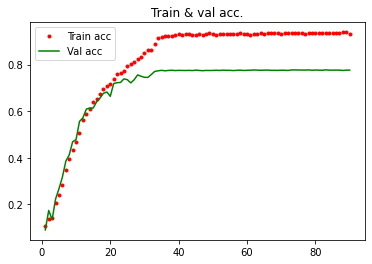

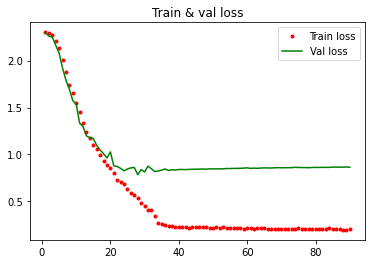

In [ ]:
acc = hist.history["accuracy"]
val_acc = hist.history["val_accuracy"]

loss = hist.history["loss"]
val_loss = hist.history["val_loss"]

epochs = range(1, num_epochs + 1)
plt.plot(epochs, acc, "r.", label="Train acc")
plt.plot(epochs, val_acc, "g", label="Val acc")
plt.title("Train & val acc.")
plt.legend()
plt.figure()

plt.plot(epochs, loss, "r.", label="Train loss")
plt.plot(epochs, val_loss, "g", label="Val loss")
plt.title("Train & val loss")
plt.legend()
plt.show()